# Final Project - Applied Data Science Capstone

Brief explanation on how the code works:
- The user enters with the name of a city
    - Search for the central coordinate of the city
    - Extract the furthest point in the `boundingbox`
    - Calculate the average between the central and the furthest coordinates to use it as the radius of the city
    - Retrieve the venues of the city by using Foursquare API
- The user enters with the name of a second city
    - Run the same procedure of the first city
- Show the Top 10 venue categories of the cities and compare them

In [1]:
# Libraries for data visualization and manipulation
import pandas as pd
import numpy as np
import pprint
from pandas import json_normalize
import matplotlib.pyplot as plot

# Library to handle requests
import requests

# Libraries for geolocation
from geopy.geocoders import Nominatim
from geopy import distance

# Libraries for map plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from folium.plugins import HeatMap

print("Libraries imported!")

Libraries imported!


In [2]:
first_city = input("Tell me the name of the first city: ")

Tell me the name of the first city: São Paulo


When we try to measure the distance between two coordinates (the furthest coordinate, i.e. the ```boundingbox``` coordinate, and the central one) is a good practice to apply the real distance between the two points, considering the globe's curvature.

In [3]:
def find_city_coords(city):
    try:
        geolocator = Nominatim(user_agent="capstone")
        location = geolocator.geocode(city)
        
        max_lat = float(max(location.raw['boundingbox'][:2]))
        max_lng = float(max(location.raw['boundingbox'][2:]))
        
        max_coord = (max_lat, max_lng)
        central_coord = (location.latitude, location.longitude)
        radius = int(distance.distance(central_coord, max_coord).m)
        
        return {"central_coord": central_coord, 
                "radius": radius}
    except:
        print("Unable to find the city!")

With the function ready to retrieve the coordinates and distances we want, let's apply it:

In [4]:
first_city_coords = find_city_coords(first_city)["central_coord"]
first_city_radius = find_city_coords(first_city)["radius"]

Now, we have all the data we need. The next step is to retrieve the information of the venues of the first city (and mainly its center) using Foursquare API.

In [5]:
CLIENT_ID = 'LQYZX1KKXGAXBXD0NXKBFQAPB5IF4QFIHJKGWRXZEN02EFZO' # Foursquare ID
CLIENT_SECRET = 'RE2RRNKD1XWKBQFRVJH0HQDYBKYHV5WOIG5C0PTQX44J1AEW' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

url_first_city = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    first_city_coords[0], 
    first_city_coords[1], 
    first_city_radius, 
    LIMIT)

results_first_city = requests.get(url_first_city).json()

JSON data is not useful to us if we can't transform it. The following two functions will be used to pick the best from this JSON, allowing us to see the nearby venues and their categories in a friendly and well known interface: **a Pandas's dataframe**.

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
def list_venues(results):
    try:
        venues = results['response']['groups'][0]['items']

        nearby_venues = json_normalize(venues)

        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues = nearby_venues.loc[:, filtered_columns]

        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

        return nearby_venues
    except:
        print("No results could be shown by now :(")

Time to check out: how well is the data we're collecting? Below, the results of the first city's venues.

In [8]:
first_city_venues = list_venues(results_first_city)
first_city_venues

,name,categories,lat,lng
0,Casa de Francisca,Music Venue,-23.548733,-46.634763
1,Centro Cultural Banco do Brasil (CCBB),Cultural Center,-23.547588,-46.634683
2,Theatro Municipal de São Paulo,Theater,-23.545477,-46.638812
3,Famiglia Franciulli,Bakery,-23.558771,-46.630604
4,Sala São Paulo,Concert Hall,-23.534303,-46.639958
...,...,...,...,...
95,Canto da Marechal,Restaurant,-23.497762,-46.632148
96,Rotisserie Patropi,Restaurant,-23.596069,-46.602166
97,The Pitchers Burger and Baseball,Burger Joint,-23.604540,-46.648559
98,Esporte Clube Pinheiros,Athletics & Sports,-23.580138,-46.688863


In [9]:
def get_total_venues(venues):
    venues = venues.groupby("categories").count().sort_values(by="lng", ascending=False)
    top_venues = venues.drop(labels=["lat","lng"], axis=1)
    top_venues.columns = ["Total Venues"]
    return top_venues

In order to have a more analytical view of the problem, we're going to search for the numbers behind these venues: how many venues of unique categories are located in this area?

In [10]:
first_city_top = get_total_venues(first_city_venues)
first_city_top.head(20)

,Total Venues
categories,
Ice Cream Shop,9
Gym,4
Bar,4
Bookstore,4
Restaurant,4
Brazilian Restaurant,4
Theater,3
Pizza Place,3
Park,3


The core data of the problem lays ahead: the dataframe above show us some insights of the city and the main pointssomeone can find by walking down there. **The only problem here is the lack of abstraction - and consequently, the need for visual data is imperative.** <br>
A way to clarify the concentration of venues is to generate a map with the data gathered so far. Let's see how it goes.

In [11]:
def generate_map(city, venues):
    
    latitude = find_city_coords(city)["central_coord"][0]
    longitude = find_city_coords(city)["central_coord"][1]
    
    map_city = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    for lat, lng, categories, name in zip(venues['lat'], venues['lng'], venues['categories'], venues['name']):
        label = '{}, {}'.format(name, categories)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)
    
    HeatMap(
        data=venues[['lat','lng']] \
            .groupby(['lat','lng']) \
            .sum().reset_index().values.tolist(), 
        radius=30,
        max_zoom=20).add_to(map_city)
    
    return map_city

In [12]:
map_first_city = generate_map(first_city, first_city_venues)
map_first_city

This completes the first part of our analysis. Now, what about comparing this city with another one? The process follows the same steps and in the end we can have a broader vision of how similar or dissimilar they are.

In [13]:
second_city = input("Now, insert the name of the second city, the one you want to compare: ")

Now, insert the name of the second city, the one you want to compare: Rio de Janeiro


In [14]:
second_city_coords = find_city_coords(second_city)["central_coord"]
second_city_radius = find_city_coords(second_city)["radius"]

In [15]:
CLIENT_ID = 'LQYZX1KKXGAXBXD0NXKBFQAPB5IF4QFIHJKGWRXZEN02EFZO' # Foursquare ID
CLIENT_SECRET = 'RE2RRNKD1XWKBQFRVJH0HQDYBKYHV5WOIG5C0PTQX44J1AEW' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

url_second_city = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    second_city_coords[0], 
    second_city_coords[1], 
    second_city_radius, 
    LIMIT)

results_second_city = requests.get(url_second_city).json()

In [16]:
second_city_venues = list_venues(results_second_city)
second_city_venues

,name,categories,lat,lng
0,Academia de Boxe Delfim,Martial Arts School,-22.919889,-43.225308
1,Estádio Jornalista Mário Filho (Maracanã),Soccer Stadium,-22.912053,-43.230075
2,Granado,Cosmetics Shop,-22.923270,-43.231170
3,Bacio di Latte,Ice Cream Shop,-22.922506,-43.235399
4,Ristorante Casa do Sardo,Italian Restaurant,-22.903560,-43.218618
...,...,...,...,...
95,Estátua de Carlos Drummond de Andrade,Outdoor Sculpture,-22.984397,-43.189202
96,Orla de Ipanema,Waterfront,-22.987791,-43.194637
97,Parque Nacional da Tijuca,National Park,-22.961421,-43.272739
98,Posto 12,Bathing Area,-22.987873,-43.225403


In [17]:
second_city_top = get_total_venues(second_city_venues)
second_city_top.head(20)

,Total Venues
categories,
Scenic Lookout,8
Beach,7
Park,4
Bookstore,4
Coffee Shop,4
Ice Cream Shop,3
Bakery,3
Mountain,3
Historic Site,3


In [18]:
map_second_city = generate_map(second_city, second_city_venues)
map_second_city

Here's the thing: in absolute terms, the best way to compare the first city and the second city is to check out the number of venues of the first versus the second (here I decided to compare my beloved **São Paulo, "Terra da Garoa"**, and other worldwide known Brazilian city, **Rio de Janeiro**). <br>
We can finally extract some answers by showing a graph of bars with the 15 most frequent venues found on the search.

In [19]:
def get_final_index(first_city, second_city, first_df, second_df):
    
    result = pd.concat([first_df, second_df], axis=1)
    result.columns = ["1st City Venues","2nd City Venues"]
    result.sort_values(by="1st City Venues", ascending=False)
    result_index = list(result.index)[:15]
    
    first_list = list(first_df["Total Venues"][:15])
    second_list = list(second_df["Total Venues"][:15])
    compare_cities = {first_city: first_list,
                      second_city: second_list}
    
    return [compare_cities, result_index]

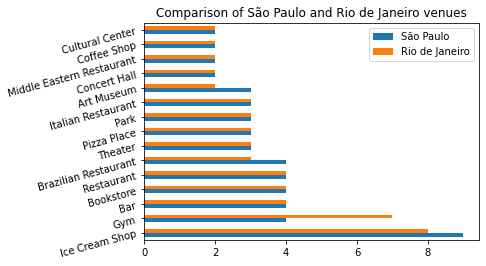

In [20]:
dataFrame = pd.DataFrame(data=get_final_index(first_city, second_city, 
                                              first_city_top, second_city_top)[0]);
dataFrame.index = get_final_index(first_city, second_city, 
                                  first_city_top, second_city_top)[1];

dataFrame.plot.barh(rot=15, title="Comparison of {} and {} venues".format(first_city, second_city));
plot.show();

Due to the limitations of the API and the lack of precise information of the venues on these two capitals (I assure you there's more in São Paulo than just *"Ice Cream Shops"!*), this project didn't achieve such a high level of ultra-mega-insightful Data Science, but I found it pretty good on showcasing some of my problem-solving skills and to demonstrate my willing to learn new subjects and to search for the best solutions to the problems I can't solve alone, because in the end our today's world is all about collaborating and advancing together. <br><br>

***Hope you enjoy it!***

## ... and that's all, folks! :)